### Image Augmentation using inbuilt keras class ImageDataGenerator, and cutout of one patch of 8 pixels with val=average of the dataset. Later used Cyclic LR which gave 1.5% improvement, from 88.5 to 90%
With heavier augmentation of imgaug, there was no improvement in 50 epochs.

In [0]:
import numpy as np
import keras
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, GlobalAveragePooling2D
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.utils import np_utils
from keras.datasets import mnist, cifar10
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/"
!ls

batch_size = 128

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


### Load pre-shuffled CIFAR data into train and test sets


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)


170500096/170498071 [==============================] - 11s 0us/step
(50000, 10)


#### https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py

In [0]:
def get_img_mean(img_dataset):
  #print(img_dataset.shape)
  avg = np.mean(img_dataset)
  return avg

def my_cutout(length, val):
  def patch(input_img):
    h = input_img.shape[0]
    w = input_img.shape[1] 
    
    mask = np.ones((h, w), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h) # specific area val clipped to 0, h, 0-h
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)
    input_img[y1: y2, x1: x2, :] = val
    # print("Patch coordinates", y1, y2, x1, x2)
    # print("Patch dim", y2-y1, x2-x1)
    return input_img
  return patch

#### Image augmentation and cutout of one patch of 8 pixels with val=average of the dataset

In [0]:
c = get_img_mean(X_train)
cutout = my_cutout(8, c)
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   zoom_range = 0.2,
                                   brightness_range=[0.8, 1.2],
                                   width_shift_range=0.15, 
                                   height_shift_range=0.15, 
                                   rotation_range=20, 
                                   horizontal_flip=True,
                                   preprocessing_function=cutout)
test_datagen = ImageDataGenerator(rescale= 1./255)

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

Steps : 391 79


#### Displaying train images

(128, 32, 32, 3)


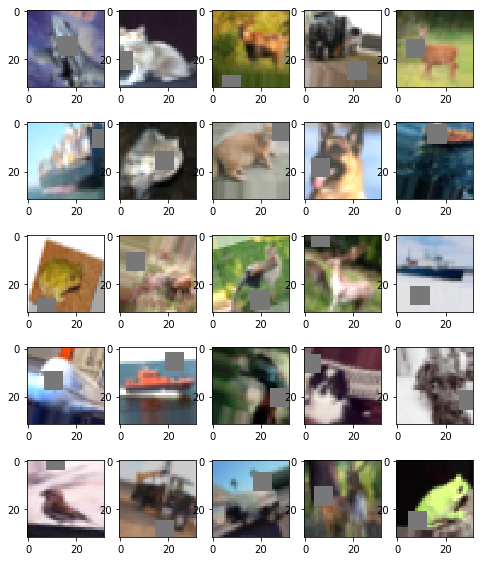

In [0]:
for i in range(15):
    x_batch, y_batch = next(train_gen)
print(x_batch.shape)

# Plot Generator images
fig = plt.figure(figsize=(8, 10))

for i in range(25):
    sub = fig.add_subplot(5, 5, i + 1)    
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

#### Taking earlier model with cifar with params 1.3m
Layer to softmax - 4x4 with rf 64.

In [0]:
def build_model():
  model = Sequential()
  
  model.add(Conv2D(48, 3, padding='same', input_shape=(32, 32, 3), activation='relu', name='conv_1', use_bias=False)) #rf 3
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(96, 3, padding='same', activation='relu', name='conv_2', use_bias=False)) 
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(64, 1, activation='relu', name='conv_3'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf10  

  model.add(Conv2D(96, 3, padding='same', activation='relu', name='conv_4', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(192, 3, padding='same', activation='relu', name='conv_5', use_bias=False)) #16, rf14
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(128, 1, activation='relu', name='conv_6'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf28
  
  model.add(Conv2D(192, 3, padding='same', activation='relu', name='conv_7', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(384, 3, padding='same', activation='relu', name='conv_8', use_bias=False))  #8, rf32
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(200, 1, activation='relu', name='conv_9'))
  model.add(MaxPooling2D(pool_size=(2, 2)))   #4, rf64
   
  model.add(Conv2D(100, 1, activation='relu', name='conv_10'))
  model.add(Conv2D(10, 4))
    
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  return model

#### Best validation accuracy with image aug and cutout and cyclic LR was **90.10% at epoch 45, when training acc was 92.89%**

In [0]:
clr_model = build_model()
clr_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])  # default is 0.001

clr_model.load_weights(dir + "cifar_cutout_clr.50-0.9011.hdf5")
print("Loaded model from disk ", clr_model.summary())

clr_model.evaluate_generator(generator=test_gen, steps=test_steps, verbose=1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 48)        1296      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 96)        41472     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 96)        0       

[0.31157470474243165, 0.9011]

In [0]:
def get_activation_heatmap(img_idx, model, layer_name):
  # After expansion, shape : (1, 32, 32, 3)
  x = np.expand_dims(X_test[img_idx], axis=0)
  
  # Normalize our image by subtracting mean RGB values from the input image
  im_proc = preprocess_input(x)
  #print("im_proc", im_proc.shape)
  
  pred_val = model.predict(im_proc)
  pred_class_idx = np.argmax(pred_val)
  #print(img_idx, " Class pred ", pred_class_idx)

  # Compute map for the topmost class, class_output shape=(?,)
  class_output = model.output[:, pred_class_idx]
    
  layer_for_gradcam = model.get_layer(layer_name)
  #print(type(layer_for_gradcam), "layer_for_gradcam", layer_for_gradcam.output.shape)
  
  # Compute the gradient of the class output value with respect to the feature map. 
  grads = K.gradients(class_output, layer_for_gradcam.output)[0]  #(?, 8, 8, 128)

  # Pool the gradients over all the axes leaving out the channel dim  
  # Mean for each channel, like GAP
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  #(128,)
  
  # iterate over tensor to get the actual values of 128 pooled_grads
  iterate = K.function([model.input], [pooled_grads, layer_for_gradcam.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])  #x - (1, 32, 32, 3)
  
  # Weigh the output feature map of conv_9 with the computed gradient values.
  for i in range(layer_for_gradcam.output.shape[3]): # output channels of the gradcam layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 
  #print("After for loop", conv_layer_output_value.shape) #(8, 8, 128)
  
  # Average the weighed feature map along the channel dimension resulting in a heat map of size 8x8  
  heatmap = np.mean(conv_layer_output_value, axis=-1)

  # Propagate only the positive values
  heatmap = np.maximum(heatmap, 0)

  # Then normalize the heat map to make the values in between 0 and 1
  heatmap /= np.max(heatmap)
  #print(heatmap[0,:])  
  
  # Resize heatmap from 8x8 to 32x32
  heatmap = cv2.resize(heatmap, (32,32))
  # Bring heatmap values between 0 and 255 for cv2 to work
  heatmap = np.uint8(255 * heatmap)
  
  # cv2 colormaps create BGR, not RGB
  #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(cv2.applyColorMap(heatmap, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
  
  # After this heatmap - 32x32x3  
  return heatmap

In [0]:
def get_correct_im(x_test):
  y_pred = clr_model.predict(x_test)
  pred_classes = np.argmax(y_pred, axis=1)
  test_classes = np.argmax(Y_test, axis=1)

  correct_im = (test_classes == pred_classes)
  
  correct_idx_list = [i for i, j in enumerate(correct_im) if j == True]
  return correct_idx_list

In [0]:
def get_incorrect_im(x_test):
  y_pred = clr_model.predict(x_test)
  pred_classes = np.argmax(y_pred, axis=1)
  test_classes = np.argmax(Y_test, axis=1)

  incorrect_im = (test_classes == pred_classes)
  
  incorrect_idx_list = [i for i, j in enumerate(incorrect_im) if j == False]
  return incorrect_idx_list

In [0]:
def plot_gradCam(model, img_list, fname_suffix):
  y_pred = model.predict(X_test)
  pred_classes = np.argmax(y_pred, axis=1)
  
  fig = plt.figure(figsize=(16, 20)) # width,height
  
  for idx, val in enumerate(img_list):    
    # heatmap - (32,32,3)
    heatmap = get_activation_heatmap(val, model, "conv_10") #(4,4,100)

    # Calculate the weighted sum of image and heatmap
    superimposed_img = cv2.addWeighted(X_test[val], 0.6, heatmap, 0.4, 0)
    final_im = cv2.hconcat([X_test[val], superimposed_img])
    
#     img_file = dir + "Images/" + fname_suffix + str(idx) +".png"
#     img = cv2.imwrite(img_file, final_im)
    #print("Saved to file", img_file)

    # Plot the concatenanted original and superimposed images
    sub = fig.add_subplot(10, 5, idx+1) # nrows, ncols, index    

    # Label - actual:predicted  
    actual_id = np.argmax(Y_test[val]) 
    #print("actual:pred", actual_id, pred_classes[val])
    label = label_dict.get(actual_id) + ":" + label_dict.get(pred_classes[val])

    sub.set_title(label)
    sub.imshow(final_im)
    
  return 

#### Gradcam on incorrectly classified images

6370
actual:pred 9 7
actual:pred 2 1
actual:pred 9 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


actual:pred 3 5
actual:pred 4 7
actual:pred 0 3
actual:pred 0 1
actual:pred 3 1
actual:pred 2 5
actual:pred 1 9
actual:pred 8 5
actual:pred 2 9
actual:pred 6 5
actual:pred 8 9
actual:pred 8 5
actual:pred 0 5
actual:pred 4 5
actual:pred 0 5
actual:pred 7 5
actual:pred 7 5
actual:pred 2 1
actual:pred 3 5
actual:pred 4 5
actual:pred 1 5
actual:pred 7 5
actual:pred 5 1
actual:pred 4 5
actual:pred 6 9
actual:pred 9 1
actual:pred 3 1
actual:pred 9 1
actual:pred 3 1
actual:pred 8 9
actual:pred 0 1
actual:pred 7 5
actual:pred 2 5
actual:pred 6 9
actual:pred 2 1
actual:pred 4 5
actual:pred 6 1
actual:pred 9 1
actual:pred 9 5
actual:pred 0 9
actual:pred 2 5
actual:pred 2 3
actual:pred 7 9
actual:pred 3 9
actual:pred 2 1
actual:pred 8 5
actual:pred 0 5


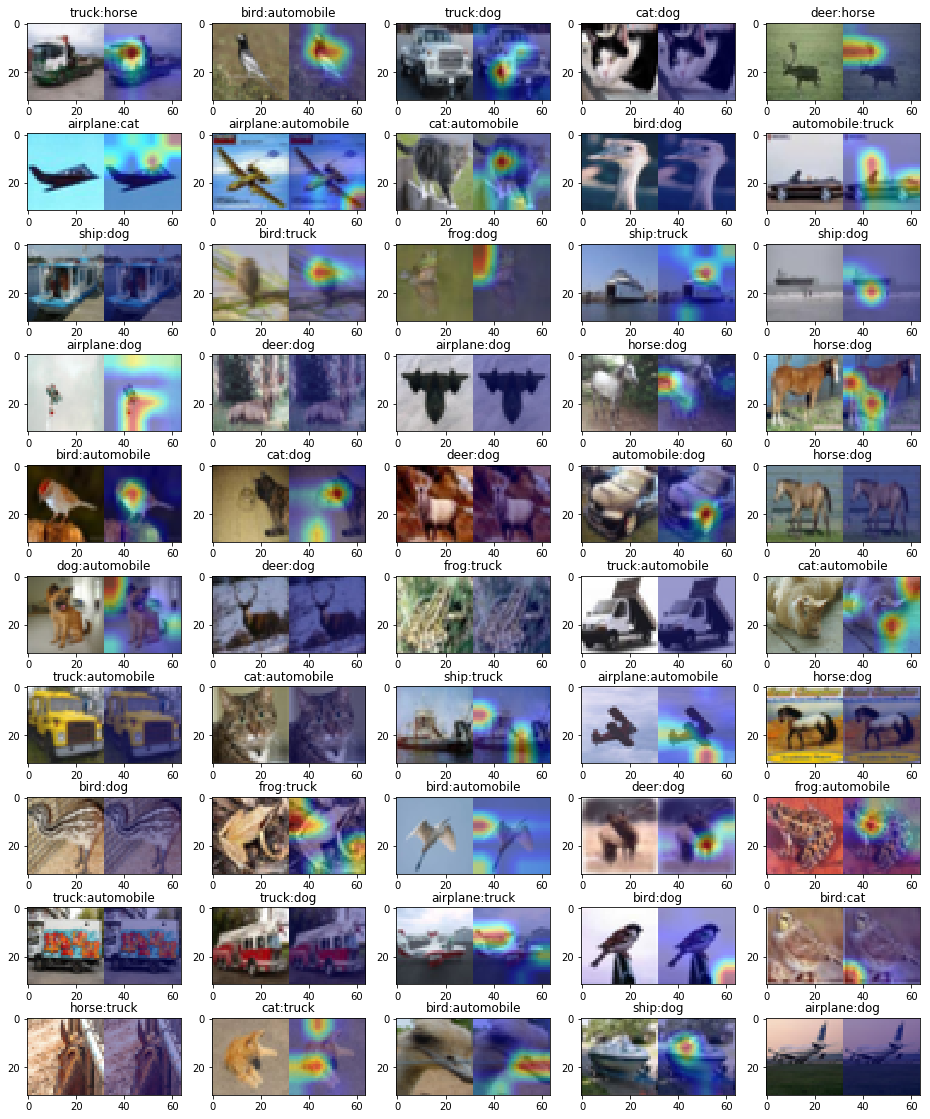

In [0]:
img_list = get_incorrect_im(X_test)
print(len(img_list))
plot_gradCam(clr_model, img_list[200:250], "")

#### Gradcam on correctly classified images
Comes out well only on SOTA architectures like Resnet

3630


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


actual:pred 5 5
actual:pred 1 1
actual:pred 6 6
actual:pred 3 3
actual:pred 9 9
actual:pred 6 6
actual:pred 9 9
actual:pred 1 1
actual:pred 1 1
actual:pred 7 7
actual:pred 9 9
actual:pred 4 4
actual:pred 1 1
actual:pred 5 5
actual:pred 6 6
actual:pred 8 8
actual:pred 5 5
actual:pred 5 5
actual:pred 3 3
actual:pred 7 7
actual:pred 9 9
actual:pred 1 1
actual:pred 3 3
actual:pred 5 5
actual:pred 3 3
actual:pred 5 5
actual:pred 9 9
actual:pred 1 1
actual:pred 1 1
actual:pred 1 1
actual:pred 7 7
actual:pred 9 9
actual:pred 1 1
actual:pred 3 3
actual:pred 6 6
actual:pred 3 3
actual:pred 3 3
actual:pred 1 1
actual:pred 6 6
actual:pred 9 9
actual:pred 9 9
actual:pred 3 3
actual:pred 2 2
actual:pred 7 7
actual:pred 3 3
actual:pred 7 7
actual:pred 5 5
actual:pred 7 7
actual:pred 2 2
actual:pred 3 3


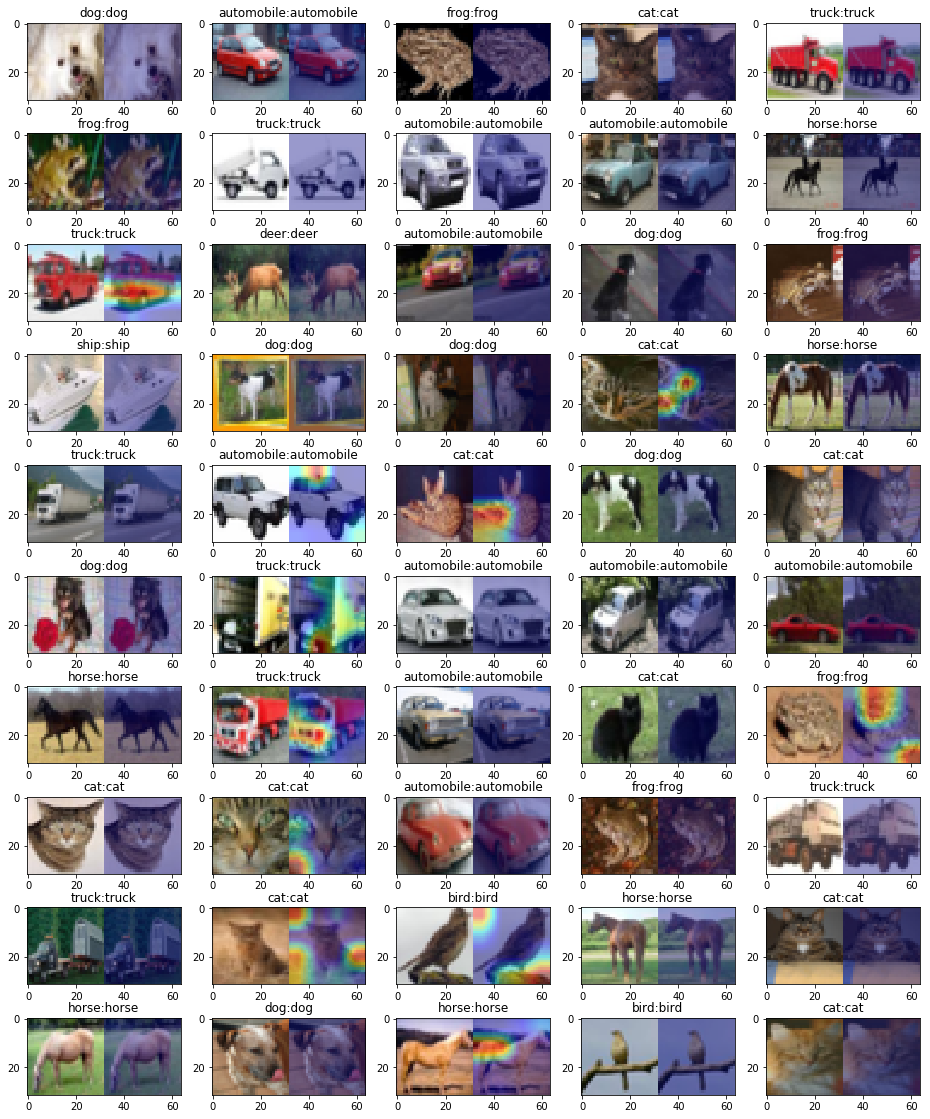

In [0]:
img_list = get_correct_im(X_test)
print(len(img_list))
plot_gradCam(clr_model, img_list[200:250], "")